<img src="images/dwave_leap.png" width="500 px" align="center">

# Getting Started with Ocean - Part 2





In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

## Example: Friends & Enemies

<img src="images/fe_8.jpg" width="800 px" align="center">

Let us start with this slightly modified Friends and Enemy example. The respective QUBO is

$$
\rm{QUBO} = -2 +2x -2xy +2yz -2zx
$$

In [2]:
import dimod 

# using the order: (x, y, z, w)
Q = {(0, 0): 2, (0, 1): -2, (1, 2): 2, (0, 2): -2}
Offset = -2

# construct the BQM
bqm = dimod.BinaryQuadraticModel.from_qubo(Q, offset=Offset)

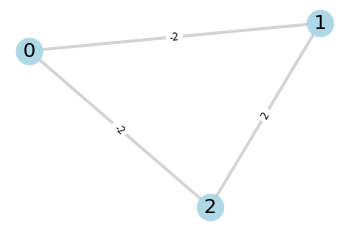

In [3]:
from utils.libqubo import show_bqm_graph
show_bqm_graph(bqm)

Now we need to get access to the QPU **solver** provided by D-Wave. A solver is a resource for solving problems. Some solvers interface to the QPU; others leverage CPU and GPU resources.

Solvers are responsible for:

- Encoding submitted problems
- Checking submitted parameters
- Decoding answers
- Adding problems to a client’s submission queue

With the solver as ressource we can use a **sampler** to obtain results for our problem. A sampler is a process that samples from low energy states of a problem’s objective function. A binary quadratic model (BQM) sampler samples from low energy states in models such as those defined by an Ising equation or a Quadratic Unconstrained Binary Optimization (QUBO) problem and returns an iterable of samples, in order of increasing energy. A dimod sampler provides ‘sample_qubo’ and ‘sample_ising’ methods as well as the generic BQM sampler method.

In [4]:
from dwave.system.samplers import DWaveSampler  

MY_TOKEN = "DEV-4ea9ebcbafb8c68bfedd0e86b9b905c68aebbacd" 

# list the names of all solvers we can access
sampler = DWaveSampler(token=MY_TOKEN, solver={'qpu': True})
print('Successfully connected to D-Wave Sampler %s.' % sampler.client.get_solver().id)

Successfully connected to D-Wave Sampler DW_2000Q_5.


In [5]:
# obtain some information about the solver we use
info = sampler.solver.data.copy()
del info['properties']['qubits']
del info['properties']['couplers']
del info['properties']['anneal_offset_ranges']
info

{'id': 'DW_2000Q_5',
 'status': 'ONLINE',
 'description': 'D-Wave 2000Q lower-noise system',
 'properties': {'num_qubits': 2048,
  'h_range': [-2.0, 2.0],
  'j_range': [-1.0, 1.0],
  'supported_problem_types': ['ising', 'qubo'],
  'parameters': {'anneal_offsets': 'A list of anneal offsets for each working qubit (NaN if unused).',
   'anneal_schedule': 'A piecewise linear annealing schedule specified by a list of points.',
   'annealing_time': 'A positive integer that sets the duration (in microseconds) of quantum annealing time.',
   'answer_mode': '',
   'auto_scale': '',
   'beta': "Boltzmann distribution parameter. Only used when postprocess is set to 'sampling'.",
   'chains': "Defines which qubits represent the same logical variable (or 'chain') when postprocessing is enabled.",
   'flux_biases': 'A list of flux biases for each working qubit.',
   'flux_drift_compensation': 'A boolean for whether to activate the flux drift compensation.',
   'h_gain_schedule': 'A piecewise linear 

Lets sample and obtain some results...

In [6]:
# sample energy space
sampleset = sampler.sample(bqm, num_reads=1000)

BinaryQuadraticModelStructureError: Problem graph incompatible with solver.

Oh... obviously our problem can not be embedded on the hardware straight forward. This happens quite often and it is known as the so called embedding problem. So solve that we have to map multiple physical qubits to logic qubits just like in the example below. Multiple physical qubits can be combined to form a logical qubit as long as the form a subset on the Hardware graph, i.e. the form a chain.

<img src="images/embedding.png" width=1000>

So before we are able to encode our problem on a certain QPU we first need to find a suitable embedding. D-Wave provides different routines to find such embeddings, e.g. `minorminer.find_embedding`, `EmbeddingComposite`, `FixedEmbedding`, `LazyEmbedding`. For course you can also manually define your own embedding and hand it to the sampler.

In [7]:
from minorminer import find_embedding
# get target structure
target_nodes, target_edges, _ = sampler.structure
# find an embedding suitable to the solver
embedding = find_embedding(Q, target_edges, verbose=2, random_seed=100)
print('\ninspect embedding:', embedding)

initialized
embedding found.
max chain length 3; num max chains=1
reducing chain lengths
max chain length 2; num max chains=1

inspect embedding: {0: [224], 1: [230], 2: [226, 229]}


In [18]:
from dwave.system.composites import FixedEmbeddingComposite, EmbeddingComposite, LazyEmbeddingComposite
# define embedded sampler

embedded_sampler = FixedEmbeddingComposite(sampler, embedding)
#embedded_sampler = LazyEmbeddingComposite(sampler)
#embedded_sampler = EmbeddingComposite(sampler)

In [16]:
# sample energy space
numruns = 1000
sampleset = embedded_sampler.sample(bqm, num_reads=numruns, chain_strength=1)
print("QPU call complete using", sampleset.info['timing']['qpu_access_time']/1000000, "seconds of QPU time for", numruns, "samples.")

QPU call complete using 0.324321 seconds of QPU time for 1000 samples.


In [17]:
# show samples
sampleset.to_pandas_dataframe()

,0,1,2,chain_break_fraction,energy,num_occurrences
0,0,1,0,0.0,-2.0,168
1,0,0,1,0.0,-2.0,202
2,1,1,1,0.0,-2.0,126
3,0,0,0,0.0,-2.0,199
4,1,1,0,0.0,-2.0,124
5,1,0,1,0.0,-2.0,181


# Workflow

1. Map your problem to a binary quadratic model (QUBO or ISING)
2. Select a solver
3. Find an Embedding of the BQM on the solver or use the D-Wave embeddings
4. Use a Sampler to sample the energy space of the BQM

# Questions:

- Whats the Embedding Problem?
- Whats the difference between a logical and a physical qubit?
- Which quantum effect is heavily made use of in a quantum annealer?
- Can any optimization problem be reformulated as a BQM?

# Exercise: 

Confirm the results from the previous Enemies & Friends problem on the QPU.

In [10]:
def sample_qubo_on_qpu(Q, shots=1000, chain=10):
    # construct BQM
    bqm = dimod.BinaryQuadraticModel.from_qubo(Q, offset=-2.0)

    # Embedd problem on QPU sampler
    sampler = DWaveSampler(token=MY_TOKEN, solver={'qpu': True})
    embedded_sampler = EmbeddingComposite(sampler)

    # sample energy space
    sampleset = embedded_sampler.sample(bqm, num_reads=shots, chain_strength=chain)

    # return samples
    return sampleset.to_pandas_dataframe()

In [11]:
Q = {(0, 0): 1, (3, 3): 1, (0, 1): -2, (1, 2): 2, (2, 3): -2}
sample_qubo_on_qpu(Q)

,0,1,2,3,chain_break_fraction,energy,num_occurrences
0,0,0,1,1,0.0,-3.0,497
1,1,1,0,0,0.0,-3.0,503


In [12]:
Q = {(0, 0): 2, (3, 3): 2, (0, 1): -2, (1, 2): 2, (2, 3): -2, (0, 3): -2}
sample_qubo_on_qpu(Q)

,0,1,2,3,chain_break_fraction,energy,num_occurrences
0,0,0,1,0,0.0,-2.0,124
1,1,1,0,1,0.0,-2.0,107
2,0,0,1,1,0.0,-2.0,103
3,1,1,1,1,0.0,-2.0,115
4,0,0,0,0,0.0,-2.0,190
5,1,1,0,0,0.0,-2.0,83
6,0,1,0,0,0.0,-2.0,183
7,1,0,1,1,0.0,-2.0,95
